# Generalization 
# UNet with 3 encoder-decoder blocks trained on 80x80 $C^\alpha$ images with varying $\alpha$



In [46]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pylab as plt
import matplotlib.colors as colors
import torch
from torch.utils.data import DataLoader

import os
import time
import sys
import argparse

sys.path.insert(0, '../code') 
from network import UNet
from model_loader_func import load_UNet
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im
from quality_metrics_func import calc_psnr, im_set_corr
from linear_approx import calc_jacobian, traj_projections
from inverse_tasks_func import synthesis
from algorithm_inv_prob import univ_inv_sol
from dataloader_func import add_noise_torch
from synthetic_data_generators import make_C_alpha_images
from scipy import stats

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
print(torch.__version__)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

1.13.1


device(type='cuda')

## Load denoisers


In [48]:

denoisers = {}
alphas =  [1,2,3,4,5]
N = 100000
for alpha in alphas:
    training_data_name = 'C_alpha'+str(alpha)+'_beta'+str(alpha)+'_line_80x80_blurredx2'
    
    start_time_total = time.time()        

    denoisers[alpha] = load_UNet(
                   base_path = '../denoisers/UNet',
                   training_data_name= training_data_name, 
                   training_noise='0to255',
                   RF=90 ,
                   set_size=str(N), 
                   swap=False);

    print("--- %s seconds ---" % (round(time.time() - start_time_total)))


--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---


In [49]:
denoisers.keys()

dict_keys([1, 2, 3, 4, 5])

## Load datasets 

In [66]:
test = {}
K = 80 # image is of dimension 80x80
for alpha in alphas:

    my_data = make_C_alpha_images(alpha=alpha, 
                        beta=alpha, 
                        separable=False, 
                        im_size=K,
                        num_samples=200, 
                        constant_background=False, 
                        factor=(2,2) , 
                        antialiasing=0, 
                        wavelet="db2", 
                        mode="reflect")
    
    test[alpha] = my_data
    
    my_data.shape

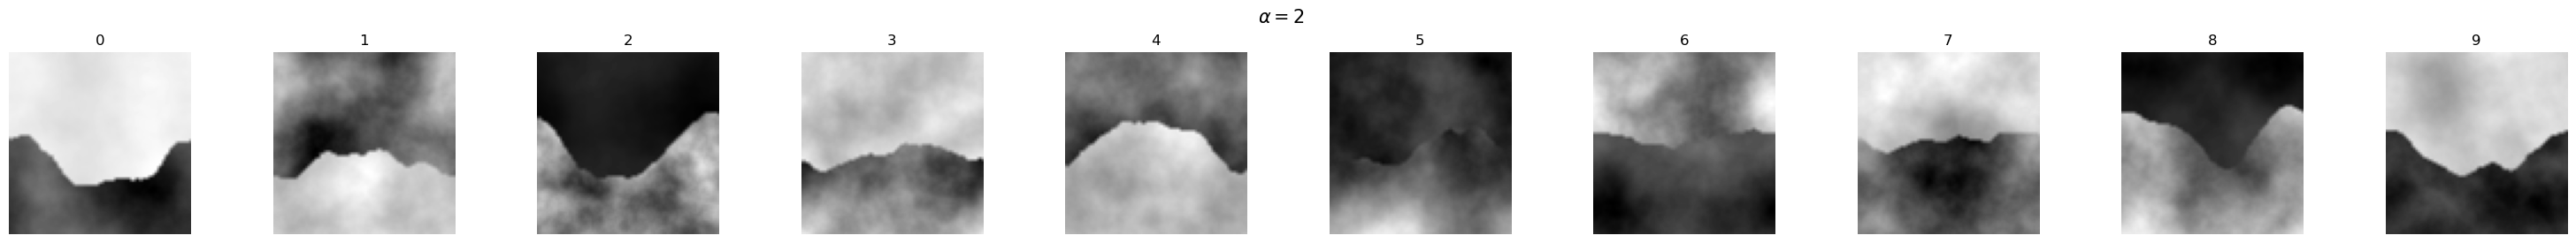

In [67]:
alpha = 2
show_im_set(test[alpha][0:10], n_columns=10, vmin=0, vmax = 1, label =r'$\alpha=$'+str(alpha))

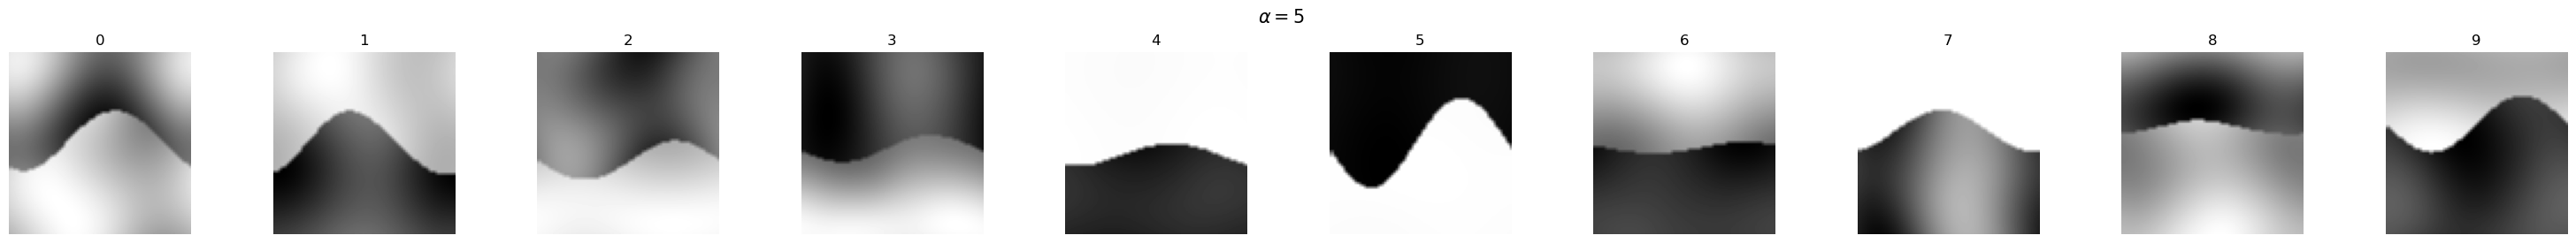

In [68]:
alpha = 5
show_im_set(test[alpha][0:10], n_columns=10, vmin=0, vmax = 1, label =r'$\alpha=$'+str(alpha))

# One shot denoising 

In [69]:
## compute psnr 
sig_range = torch.round(torch.logspace(np.log10(5),np.log10(255),15))

psnr_test = {}
psnr_train = {}
for alpha in alphas: 
    psnr_test[alpha] = {}
    data = test[alpha]
    if N <200: 
        data = torch.tile(data, dims=(int(200/N) , 1,1,1))
    else: 
        data = data[0:200]        

    loader = DataLoader(dataset=data, batch_size=200, shuffle=False)
    try:
        print(alpha)
        psnr_test[alpha] = calc_psnr(denoisers[alpha],loader,sig_range , device)
    except KeyError: 
        pass



1
2
3
4
5


1
2
3
5


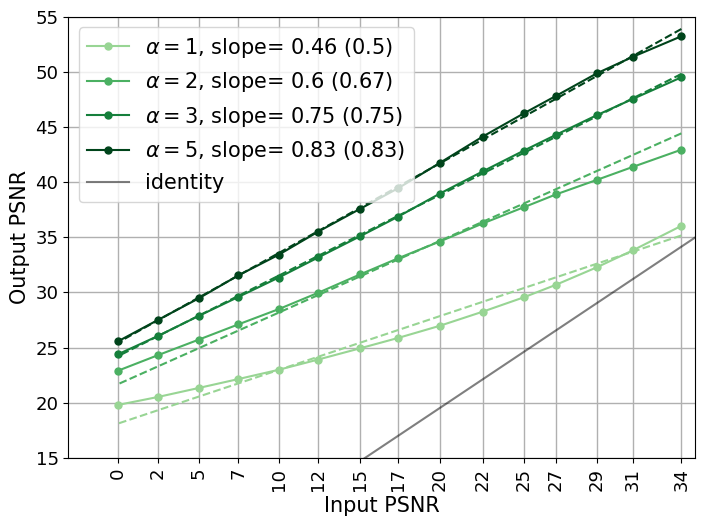

In [70]:
## plot 
def intercept_only_fit(slope,x,y): 
    return   (y-(slope * x ) ).mean()

def expected_slope(alpha): 
    return alpha/(alpha+1)

f , axs = plt.subplots(1,1, figsize=(7,5), sharex = True, sharey=True)
plt.tight_layout()
x_axis = [ -10*np.log10( (float(std)/255)**2  ) for std in psnr_test[1].keys()]

for alpha in [1,2,3,5]: 
    print(alpha)   
    slope, _, _, _, _ = stats.linregress(x_axis, [psnr_test[alpha][key] for key in psnr_test[alpha].keys()])
    
    exp_slope=expected_slope(alpha)
    intercept = intercept_only_fit(exp_slope, torch.tensor(x_axis), torch.tensor([psnr_test[alpha][key] for key in psnr_test[alpha].keys()]))

    label = r'$\alpha=$'+str(alpha) + ', slope= ' + str(round(slope,2))+' (' + str(round(exp_slope,2))+')' 

    axs.plot(x_axis, [psnr_test[alpha][key] for key in psnr_test[alpha].keys()], 
                marker = '.',markersize = 10,label = label, alpha = 1)
    

    plt.plot(x_axis, torch.tensor(x_axis)*exp_slope + intercept, alpha = 1, ls='--')
    
    
    axs.set_xticks(x_axis);
    axs.grid(  linewidth=1);
    axs.set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
    axs.set_xlim(-3, 35)
    
    y_axis = np.linspace(10,60,5) 
    axs.set_yticks(y_axis);
    
    axs.set_yticklabels(np.round(y_axis).astype(int) , fontsize=15);
    axs.set_ylim(15, 55)
    
    axs.set_xticks(x_axis);
    axs.grid(  linewidth=1);
    axs.set_yticks(range(15,60,5));
    axs.set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=13)
    plt.yticks( fontsize = 13);
    axs.set_yticklabels( range(15,60,5), fontsize=13)

    colormap = plt.cm.Greens #nipy_spectral, Set1,Paired   
    plot_colors = [colormap(i) for i in np.array([.4,.4,.6,.6,.8,.8,1,1]) ]
    for k,j in enumerate(axs.lines):
        j.set_color(plot_colors[k])
axs.plot( [0,35],[0,35] ,'k', alpha = .5, label = 'identity');

axs.legend(fontsize = 15);
axs.set_xlabel('Input PSNR', fontsize = 15)
axs.set_ylabel('Output PSNR', fontsize = 15);


# Jacobian Analysis 

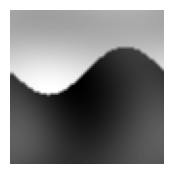

In [71]:
alpha = 5
n = 9
im = test[alpha][n:n+1].to(device)
plot_single_im(im)


In [72]:
sigma = 100/255
noise = torch.randn(1,1,K,K).to(device)*sigma 
noisy = im + noise
denoised =  noisy - denoisers[alpha](noisy).detach()


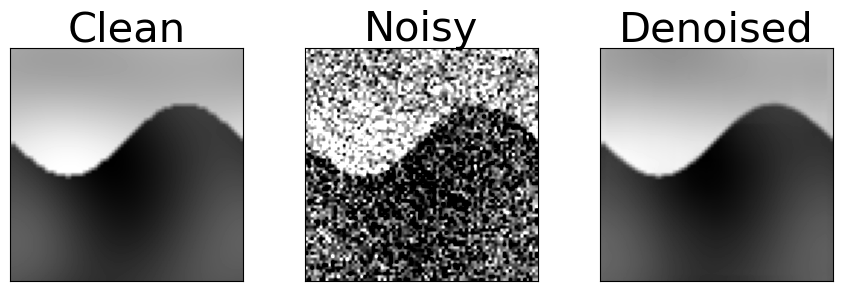

In [73]:

f , axs = plt.subplots(1,3 , figsize=(9,3))
f.tight_layout()


fig = axs[0].imshow(im.squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[0].set_title('Clean', fontsize=30)

fig = axs[1].imshow(noisy.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[1].set_title('Noisy', fontsize=30)

fig = axs[2].imshow(denoised.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[2].set_title('Denoised', fontsize=30);


In [74]:
I = torch.eye(K**2).to(device)
J = calc_jacobian(noisy, denoisers[alpha])
U,S, V = torch.svd(I - J)

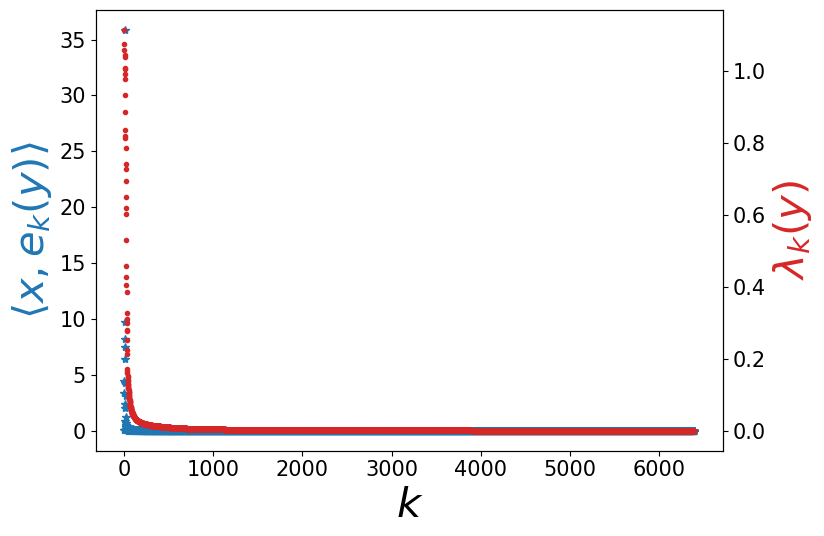

In [75]:
cors = []
for j in range(K*K): 
    cors.append( torch.dot(U[:,j], im.flatten() ).cpu() )
cors = torch.stack(cors)  

f, ax1 = plt.subplots(1,1, figsize = (7,5), sharey=False )
plt.tight_layout()

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '*', label = r'$ \langle x,e_k\rangle $', alpha = 1)
ax1.set_ylabel(r'$\langle x,e_k(y)\rangle $', color=color,fontsize = 30)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15);

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color=color, fontsize = 30, rotation=90)
ax2.plot(S.cpu(), '.', alpha = 1, color=color);
plt.yticks( fontsize = 15);


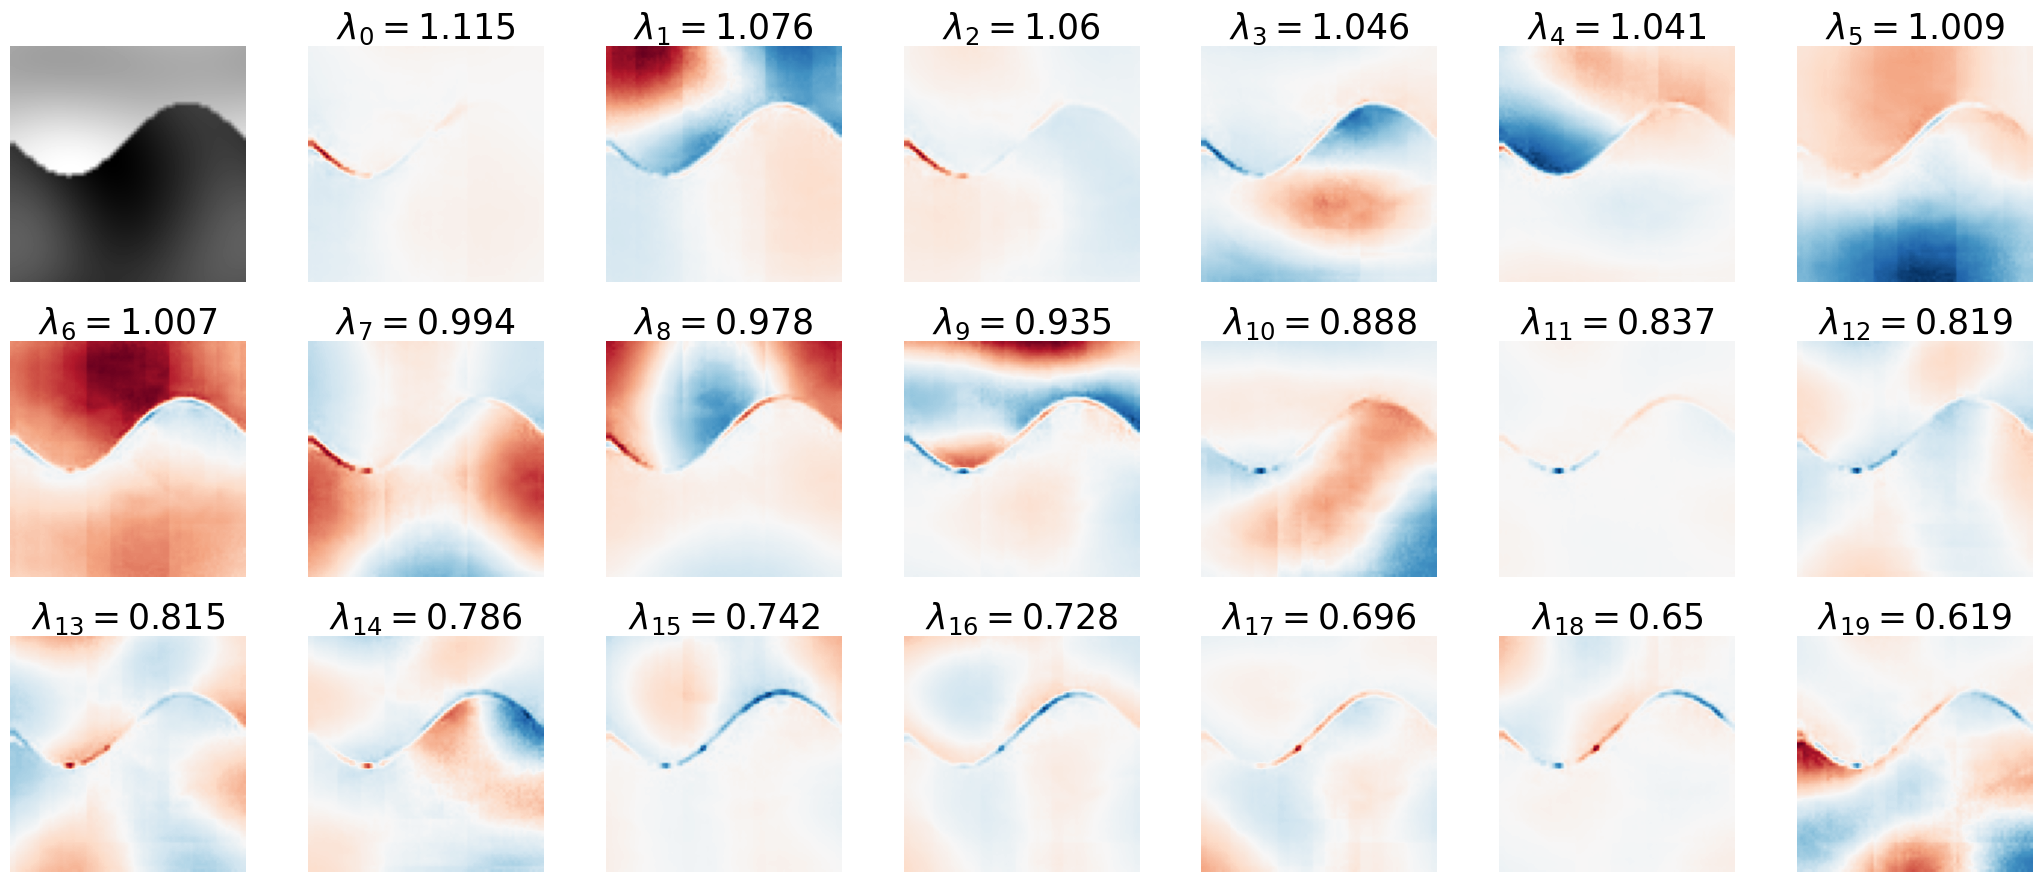

In [76]:
k = 20
skips = 1
shift = 0
ids = np.concatenate([range(shift,k*skips+shift, skips) ])

f, axs = plt.subplots(3,7, figsize = (7*3,3*3))
plt.tight_layout()
axs = axs.ravel()

axs[0].imshow(im.cpu().squeeze(), 'gray')

for i in range(k): 
    j = ids[i]
    v_lim = max(abs(V[:,j].min()), abs(V[:,j].max())).item()
    axs[i+1].imshow(V[:,j].reshape(noisy.shape[2], noisy.shape[3]).cpu(), 'RdBu',norm=colors.CenteredNorm()) 
    axs[i+1].set_title(r'$\lambda_{'+str(j)+'}=$' +str(round(S[j].cpu().item() ,3)) , fontsize = 25)
for i in range(len(axs)): 
    axs[i].axis('off');

    

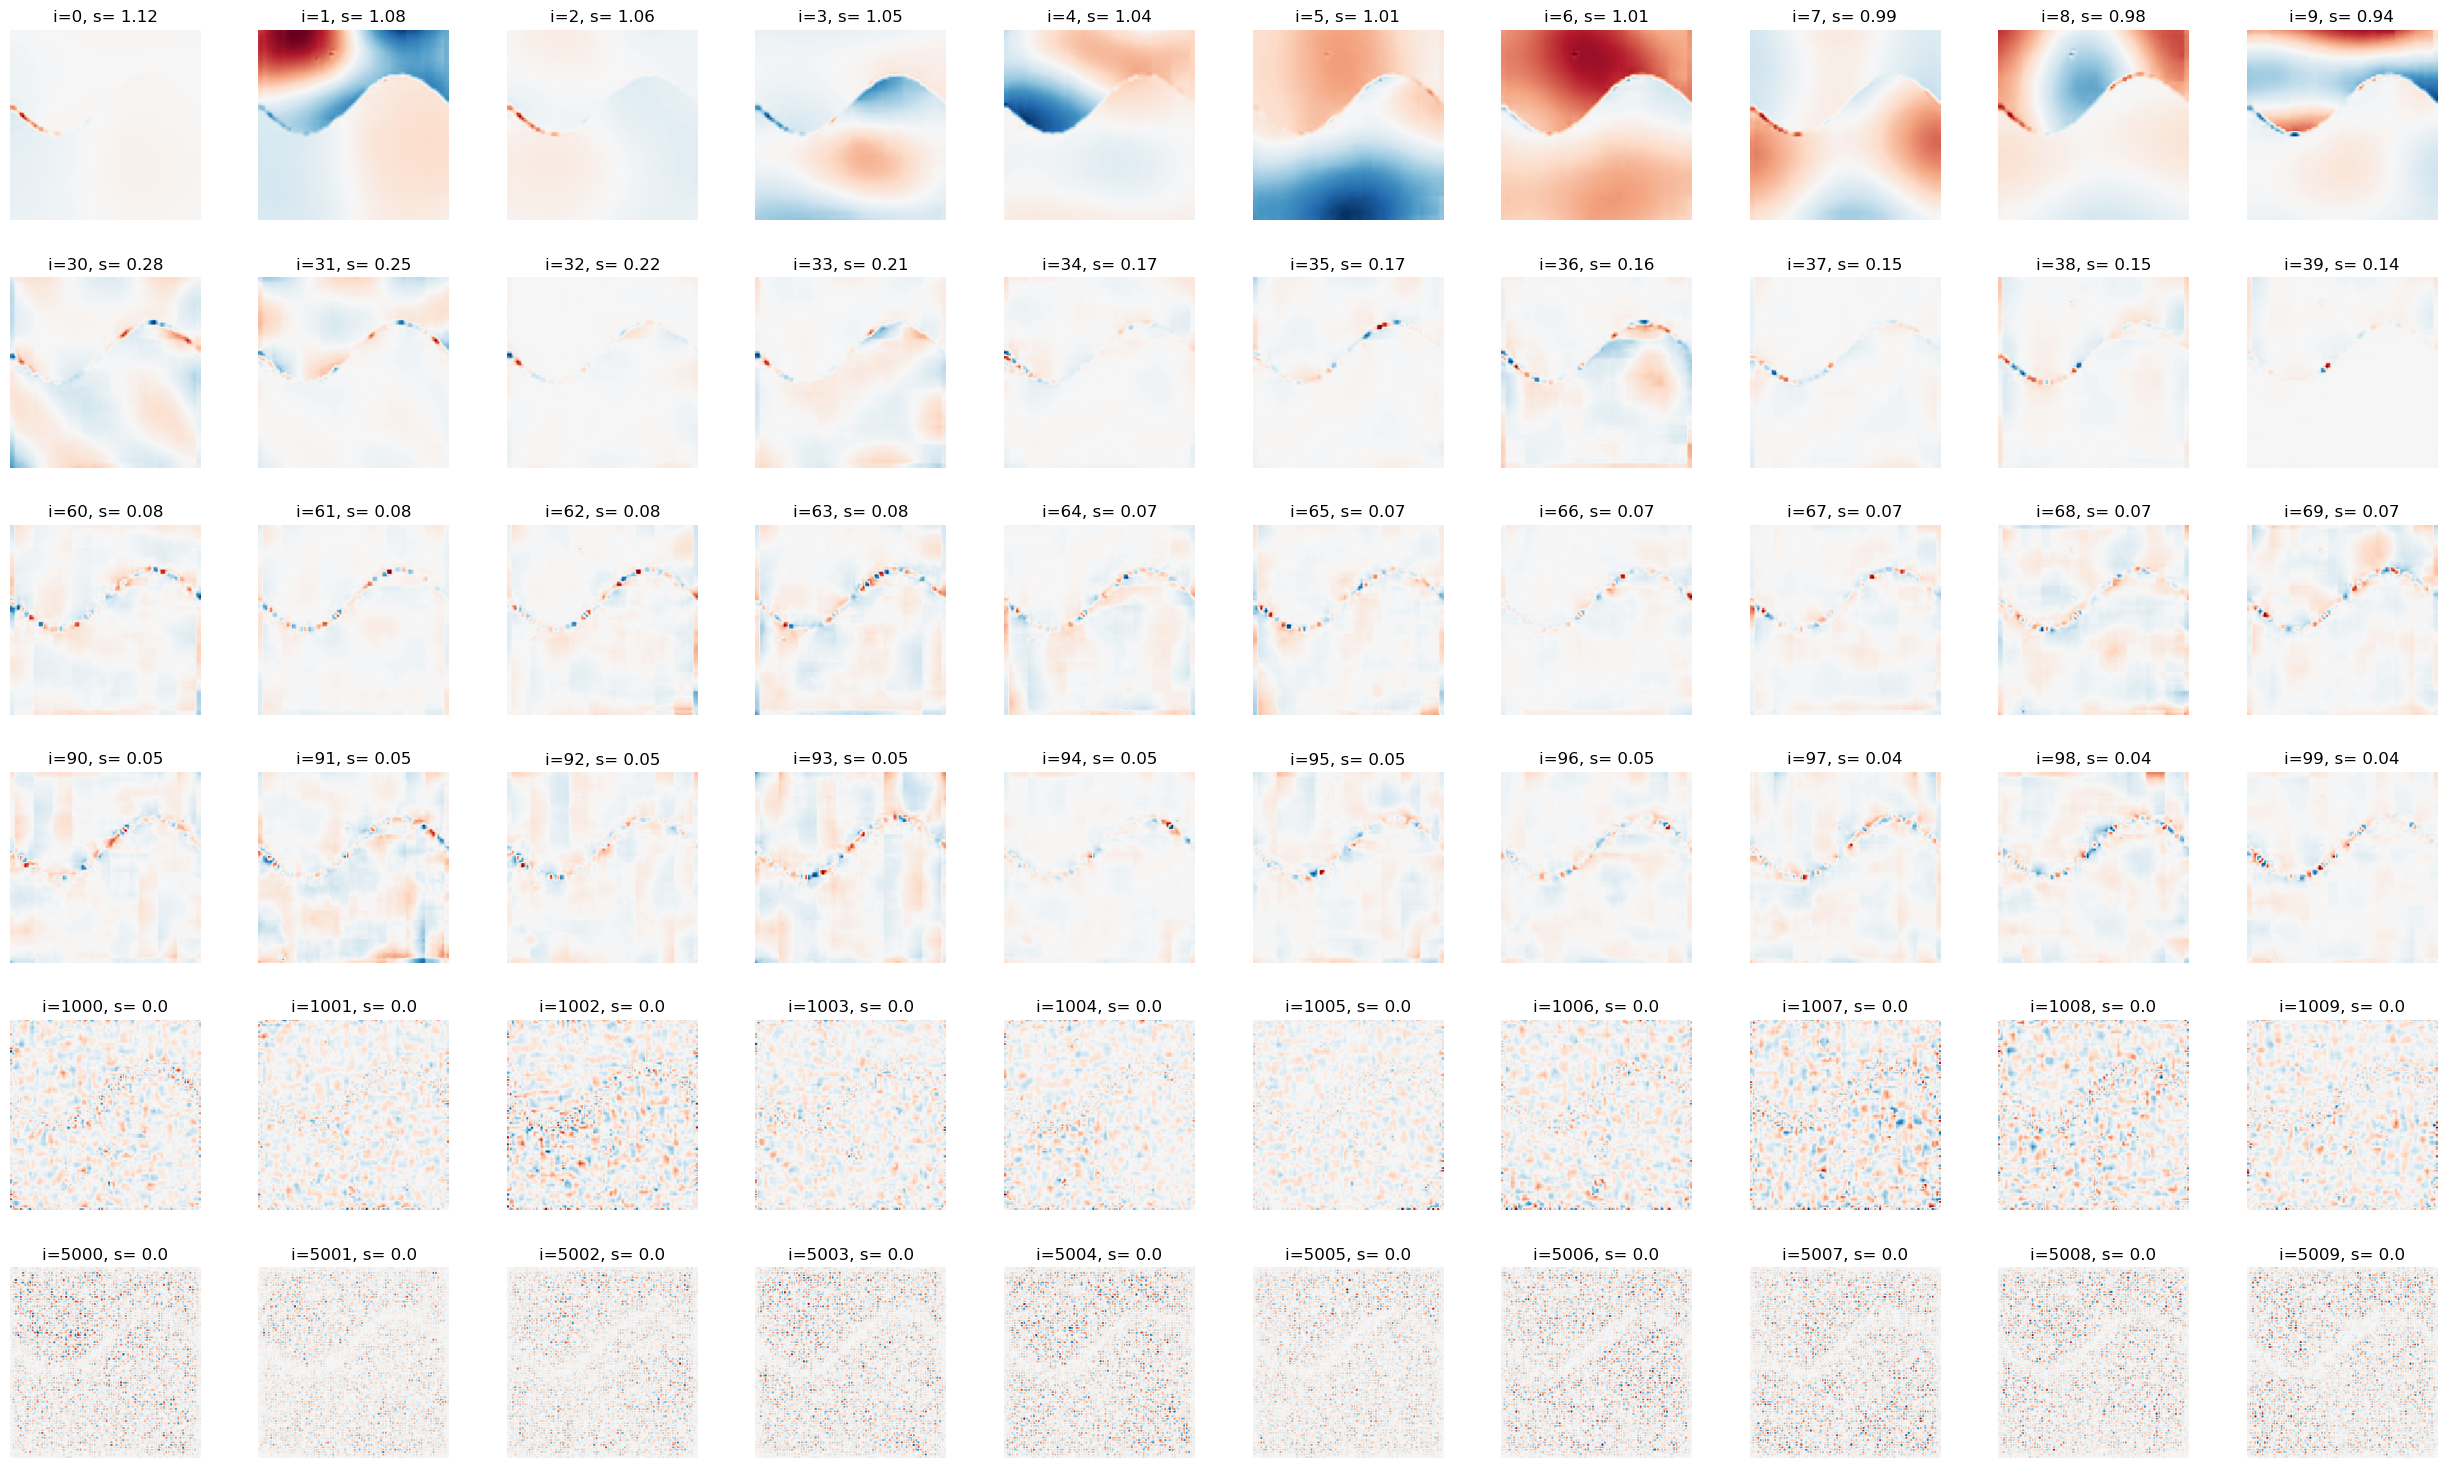

In [77]:
ids = np.concatenate([range(0,10),range(30,40),range(60,70),range(90,100) , range(1000,1010), range(5000,5010)])

f, axs = plt.subplots(6,10, figsize = (10*2.5,6*2.5))
plt.tight_layout()
axs = axs.ravel()

for i in range(60): 
    j = ids[i]
    v_lim = max(abs(U[:,j].min()), abs(U[:,j].max())).item()    
    axs[i].imshow(U[:,j].cpu().numpy().reshape(K,K), 'RdBu',vmin=-v_lim, vmax = v_lim)
    axs[i].set_title('i='+str(j)+', s= ' + str(round(torch.abs(S)[j].item(),2)) )
for i in range(len(axs)): 
    axs[i].axis('off');

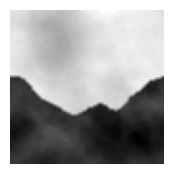

In [79]:
alpha = 2
n = 9
im = test[alpha][n:n+1].to(device)
plot_single_im(im)


In [80]:
sigma = 100/255
noise = torch.randn(1,1,K,K).to(device)*sigma 
noisy = im + noise
denoised =  noisy - denoisers[alpha](noisy).detach()


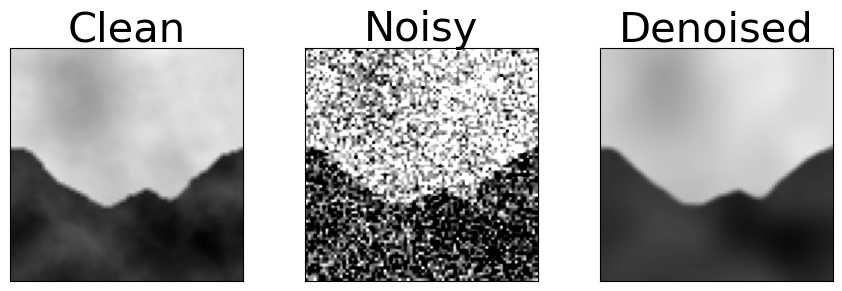

In [81]:

f , axs = plt.subplots(1,3 , figsize=(9,3))
f.tight_layout()


fig = axs[0].imshow(im.squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[0].set_title('Clean', fontsize=30)

fig = axs[1].imshow(noisy.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[1].set_title('Noisy', fontsize=30)

fig = axs[2].imshow(denoised.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
axs[2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
axs[2].set_title('Denoised', fontsize=30);
# plt.savefig(results_dir + 'denoised_im.pdf',bbox_inches='tight')    


In [82]:
I = torch.eye(K**2).to(device)
J = calc_jacobian(noisy, denoisers[alpha])
U,S, V = torch.svd(I - J)

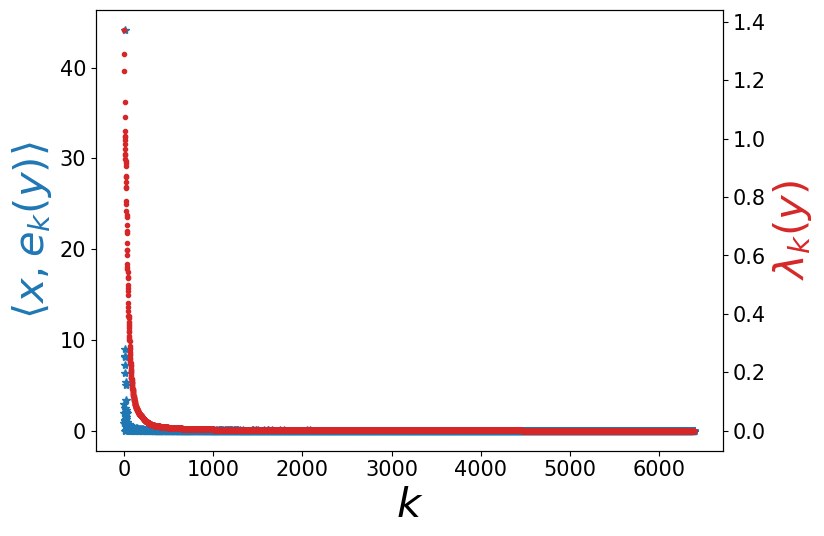

In [83]:
cors = []
for j in range(K*K): 
    cors.append( torch.dot(U[:,j], im.flatten() ).cpu() )
cors = torch.stack(cors)  

f, ax1 = plt.subplots(1,1, figsize = (7,5), sharey=False )
plt.tight_layout()

color = 'tab:blue'
ax1.set_xlabel(r'$k$', fontsize=30)
ax1.plot(abs(cors.cpu()), '*', label = r'$ \langle x,e_k\rangle $', alpha = 1)
ax1.set_ylabel(r'$\langle x,e_k(y)\rangle $', color=color,fontsize = 30)
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15);

color = 'tab:red'
ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda_k(y)$', color=color, fontsize = 30, rotation=90)
ax2.plot(S.cpu(), '.', alpha = 1, color=color);
plt.yticks( fontsize = 15);


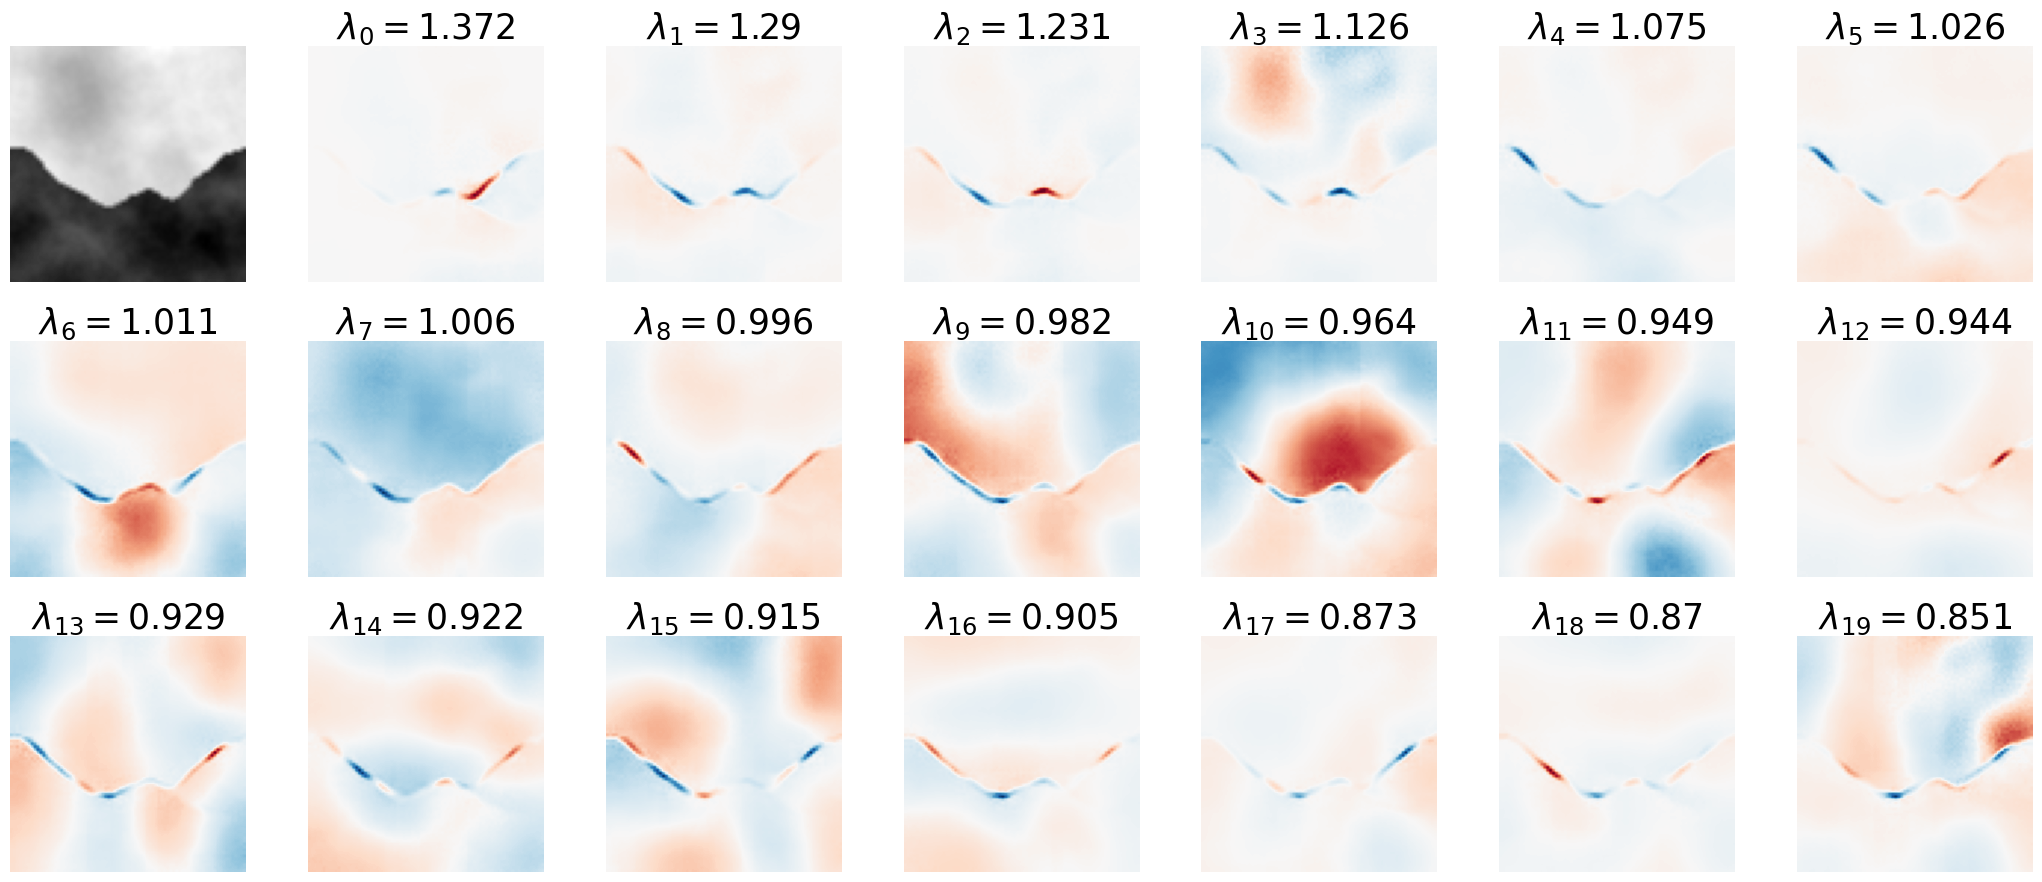

In [84]:
k = 20
skips = 1
shift = 0
ids = np.concatenate([range(shift,k*skips+shift, skips) ])

f, axs = plt.subplots(3,7, figsize = (7*3,3*3))
plt.tight_layout()
axs = axs.ravel()

axs[0].imshow(im.cpu().squeeze(), 'gray')

for i in range(k): 
    j = ids[i]
    v_lim = max(abs(V[:,j].min()), abs(V[:,j].max())).item()
    axs[i+1].imshow(V[:,j].reshape(noisy.shape[2], noisy.shape[3]).cpu(), 'RdBu',norm=colors.CenteredNorm()) 
    axs[i+1].set_title(r'$\lambda_{'+str(j)+'}=$' +str(round(S[j].cpu().item() ,3)) , fontsize = 25)
for i in range(len(axs)): 
    axs[i].axis('off');

 

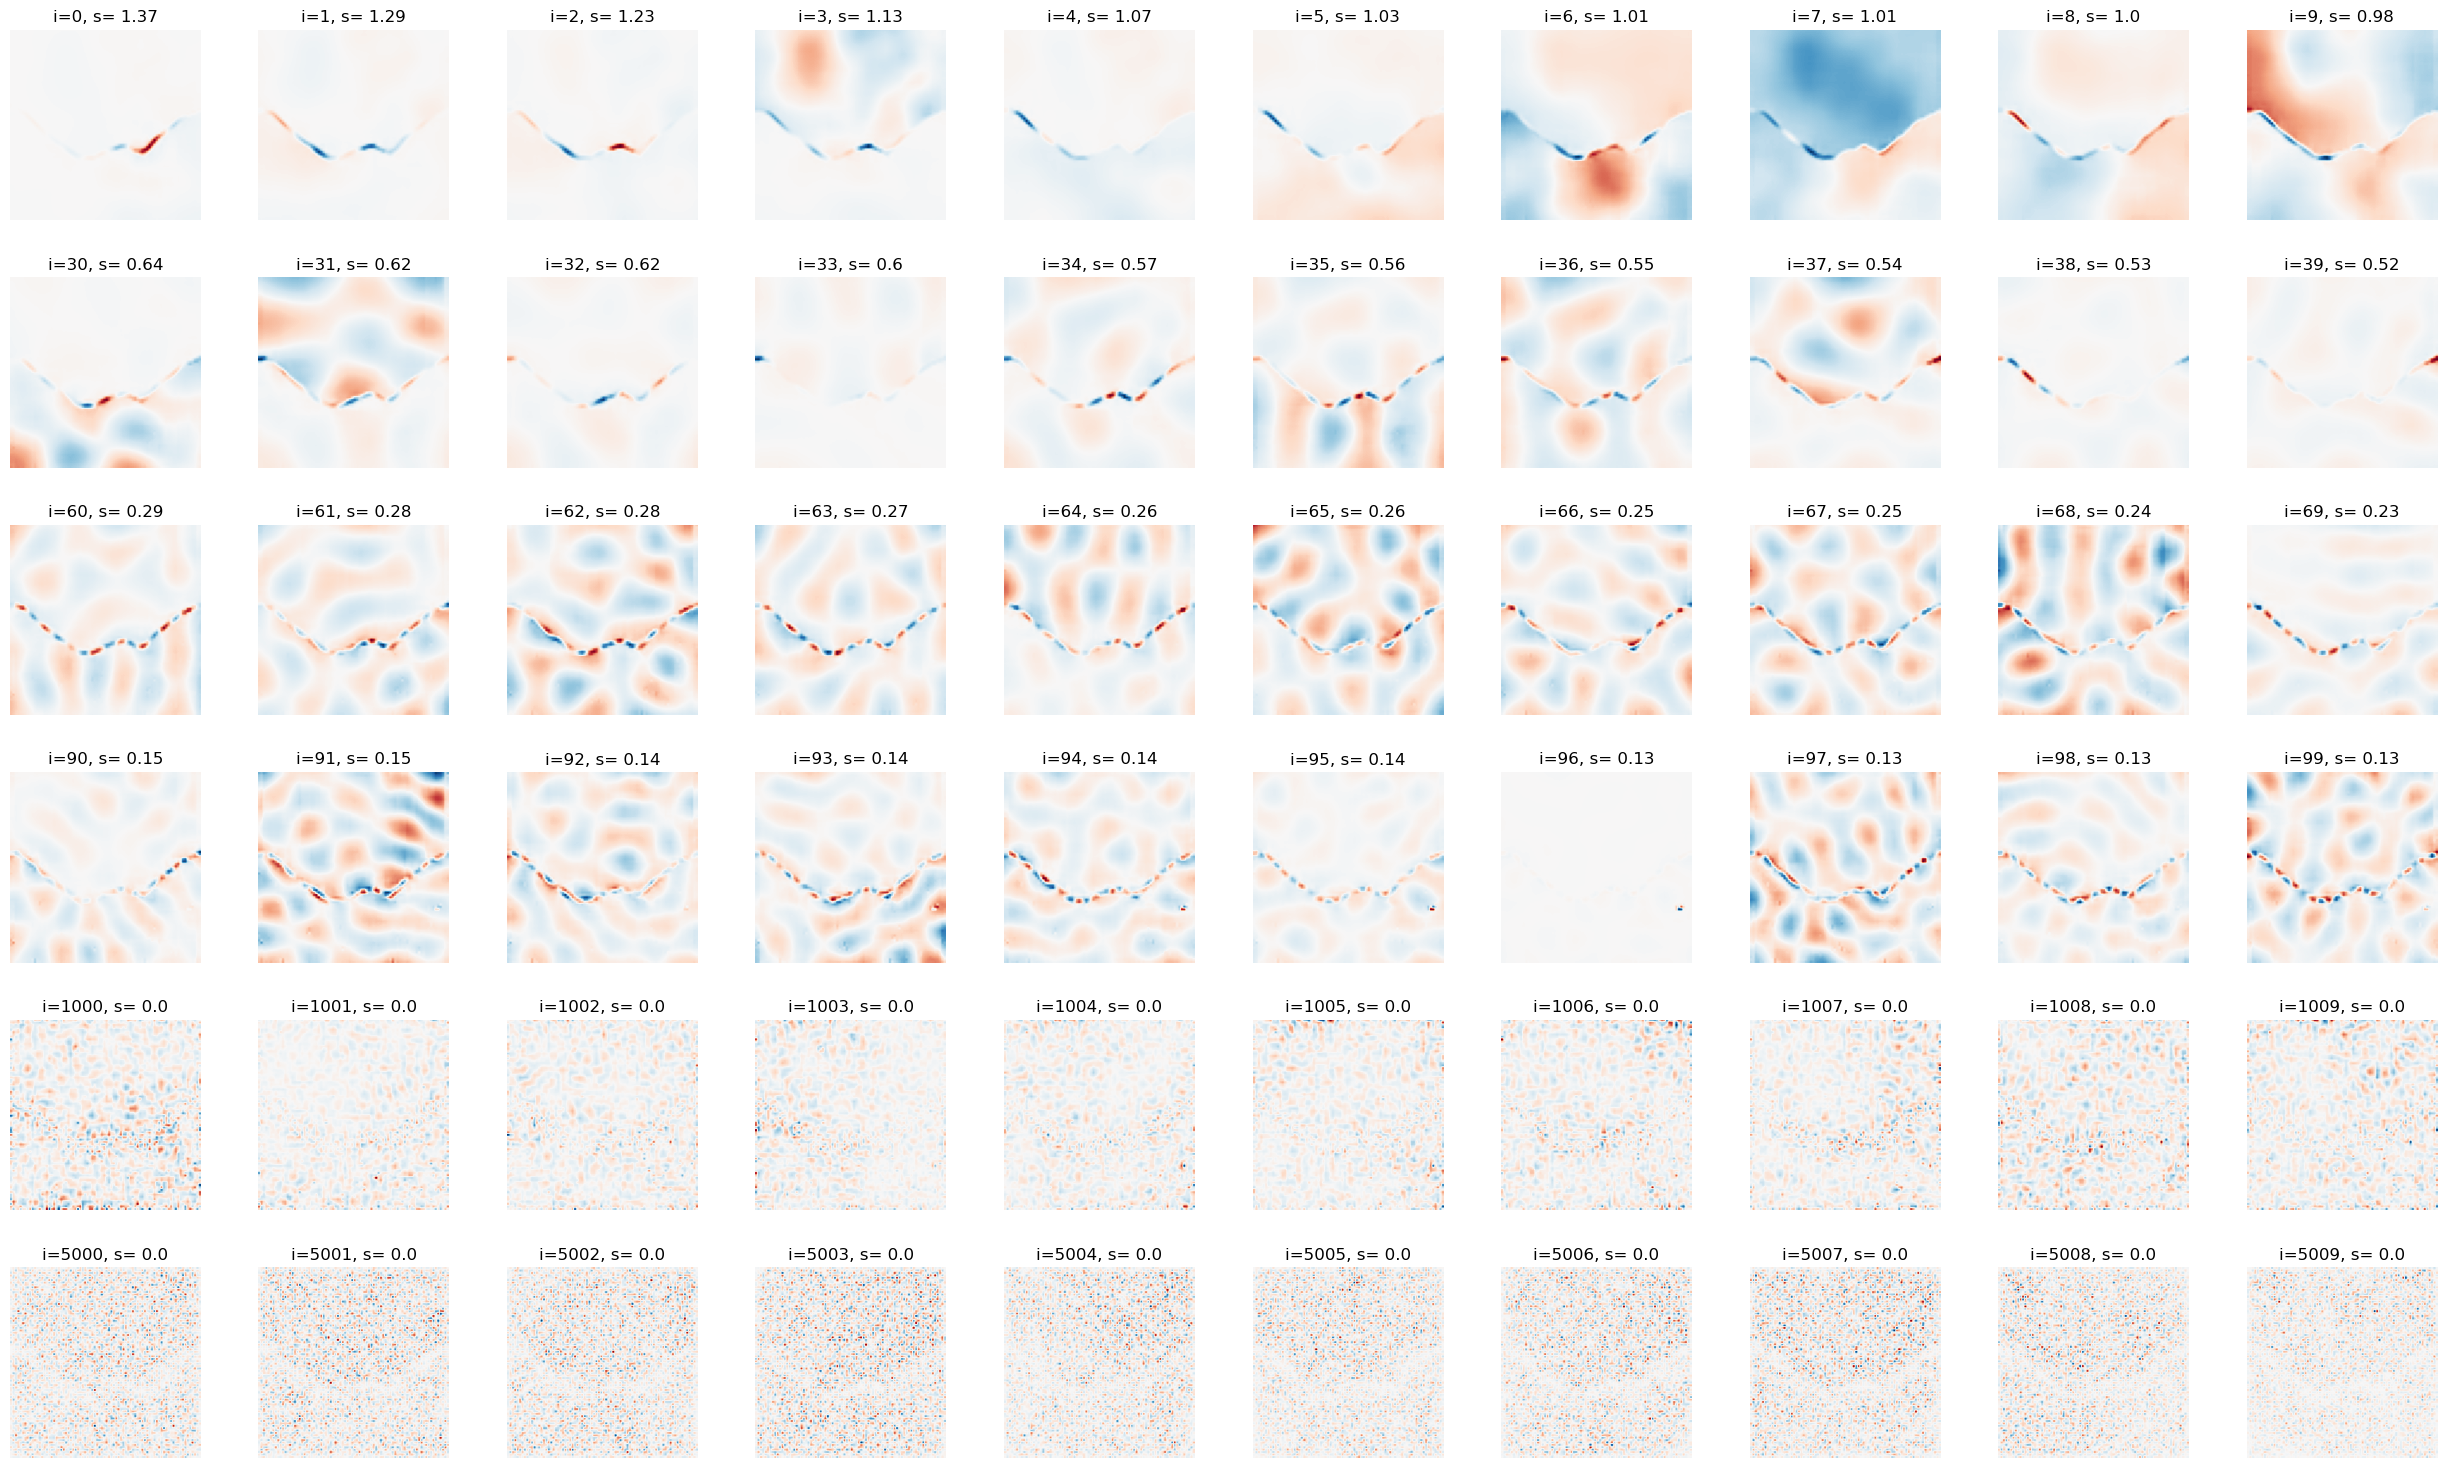

In [85]:
ids = np.concatenate([range(0,10),range(30,40),range(60,70),range(90,100) , range(1000,1010), range(5000,5010)])

f, axs = plt.subplots(6,10, figsize = (10*2.5,6*2.5))
plt.tight_layout()
axs = axs.ravel()

for i in range(60): 
    j = ids[i]
    v_lim = max(abs(U[:,j].min()), abs(U[:,j].max())).item()    
    axs[i].imshow(U[:,j].cpu().numpy().reshape(K,K), 'RdBu',vmin=-v_lim, vmax = v_lim)
    axs[i].set_title('i='+str(j)+', s= ' + str(round(torch.abs(S)[j].item(),2)) )
for i in range(len(axs)): 
    axs[i].axis('off');